In [1]:
# calibrate the wavelength of lamp spectra extracted by pyrafspec

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [187]:
from astropy import table
from astropy.io import fits
import numpy as np
from pyrafspec.fitslist import *
import matplotlib.pyplot as plt
import os
from PyAstronomy import pyasl
from astropy import coordinates as coord
import joblib
import collections
plt.style.use('lijiaostyle')
from pyrafspec.obslog import *

In [179]:
filename = '../data/template/test/20210102028_1ds.fits'
data,head = fits.getdata(filename,header=True)

In [183]:
data.shape

(95, 4096)

In [181]:
multispec_items = MultiSpecItem.get_wat2(head)
orders = np.arange(len(multispec_items))+1
waves = np.zeros(data.shape,dtype=np.float32)
for _i, _order in enumerate(orders):
    waves[_i] = multispec_items[_order].get_wv()

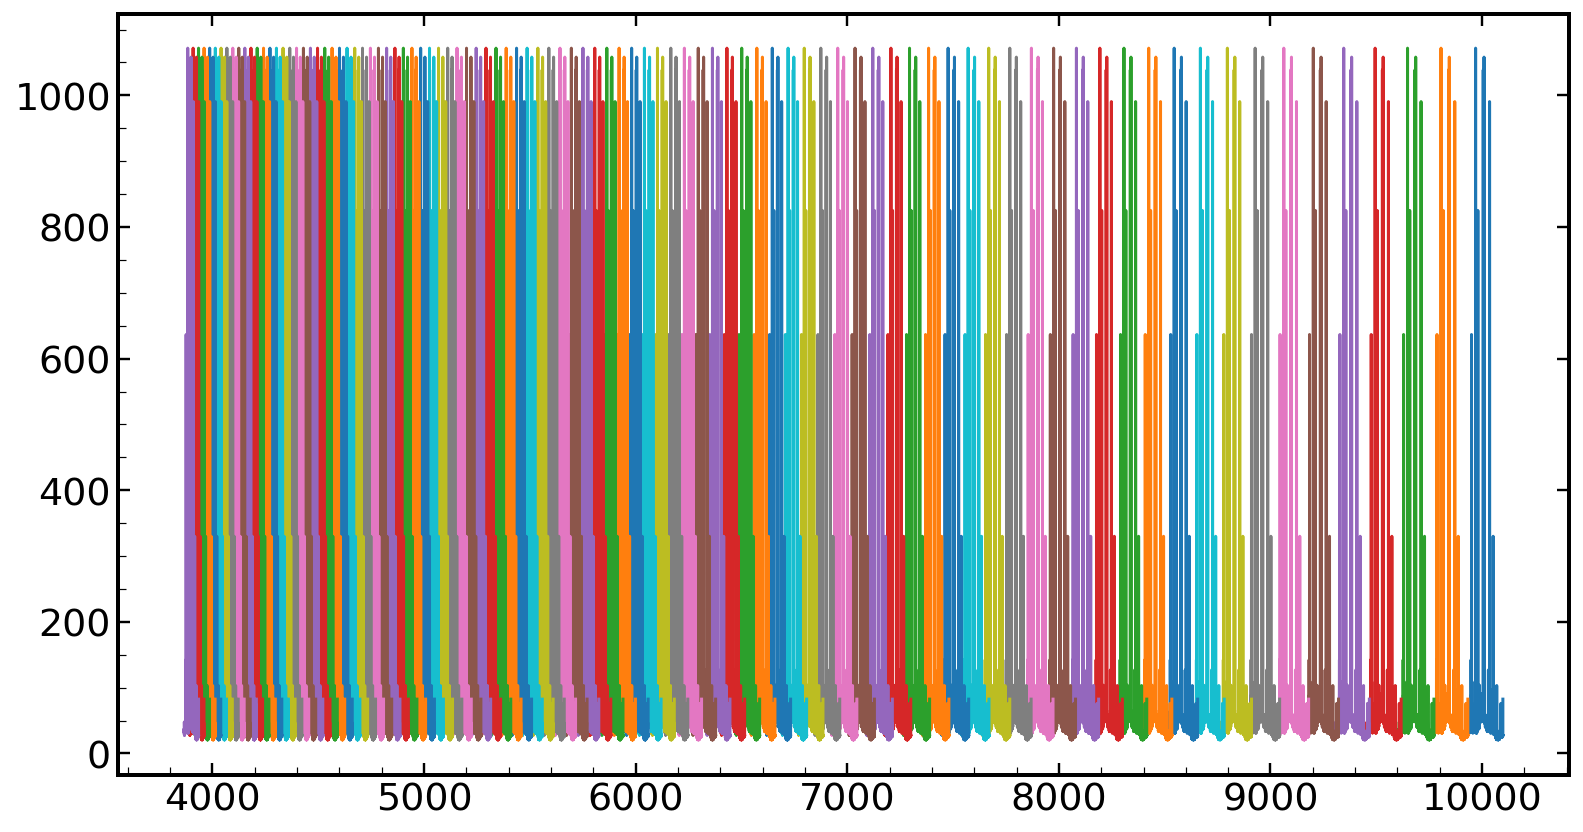

In [182]:
fig, ax = plt.subplots(1,1, figsize=(13,7),sharex=True)
plt.subplots_adjust(hspace=0)
_ = plt.plot(waves.T, np.sqrt(data[0]).T)

In [60]:
logfile = '/home/lcq/Documents/pyrafspec/pyfile/HRS240/20210207_test.obslog'
log = read_log(logfile)
#lamplist

/home/lcq/Documents/pyrafspec/pyfile/HRS240/20210207_test.obslog


In [41]:
direname = os.path.dirname(log.filename_composition)

In [45]:
fname = os.path.join(direname, '20210207016_1ds.fits')

In [206]:
from twodspec.polynomial import Poly1DFitter
from twodspec.trace import trace_naive_max
from astropy import table
from astropy.io import fits
from twodspec import thar

def calibrate_wave(lampsumfits, templatename= None, linelistname=None,
                   pw=1, deg=2, threshold=0.1, min_select=20,
                   nsigma=2.5, verbose=False, suffix='_wv'):
    '''calibrate the wavelength
    parameters:
    ----------------------
    lampsumfits [str] e.g.  20210102028_1ds.fits
    returns:
    --------------------
    calibration_dict [dictionary]
    '''
    if templatename is None:
       templatename = '../template/240HRStemplate/20210102028_1ds.fits'
    if 'dump' in templatename:
        import joblib
        dumpdata = joblib.load(templatename)
        wave_temp = dumpdata['wave']
        lamp_temp = dumpdata['flux']
    else:
        lamp_temp,head= fits.getdata(templatename,header=True)
        multispec_items = MultiSpecItem.get_wat2(head)
        orders = np.arange(len(multispec_items))+1
        wave_temp = np.zeros(lamp_temp.shape,dtype=np.float32)
        for _i, _order in enumerate(orders):
            wave_temp[_i] = multispec_items[_order].get_wv()
    
    if linelistname is None:
       linelistname = '../linelist/thar.dat'
    linelist = np.loadtxt(linelistname)
    lamp1d, header = fits.getdata(lampsumfits,header=True)
    wave_init = thar.corr_thar(wave_temp, lamp_temp, lamp1d, maxshift=50)
    #find lamp lines
    tlines = thar.find_lines(wave_init, lamp1d, linelist, npix_chunk=20, ccf_kernel_width=1.5)
    ind_good = np.isfinite(tlines["line_x_ccf"]) & (np.abs(tlines["line_x_ccf"] - tlines["line_x_init"]) < 10) & (
            (tlines["line_peakflux"] - tlines["line_base"]) > 100) & (
                       np.abs(tlines["line_wave_init_ccf"] - tlines["line"]) < 3)
    tlines.add_column(table.Column(ind_good, "ind_good"))
    # tlines.show_in_browser()
    #clean each order
    def clean(pw=1, deg=2, threshold=0.1, min_select=20):
        order = tlines["order"].data
        ind_good = tlines["ind_good"].data
        linex = tlines["line_x_ccf"].data
        z = tlines["line"].data

        u_order = np.unique(order)
        for _u_order in u_order:
            ind = (order == _u_order) & ind_good
            if np.sum(ind) > 10:
                # in case some orders have only a few lines
                p1f = Poly1DFitter(linex[ind], z[ind], deg=deg, pw=pw)
                res = z[ind] - p1f.predict(linex[ind])
                ind_good[ind] &= np.abs(res) < threshold
        tlines["ind_good"] = ind_good
        return
    
    print("  |- {} lines left".format(np.sum(tlines["ind_good"])))
    clean(pw=1, deg=2, threshold=0.8, min_select=20)
    clean(pw=1, deg=2, threshold=0.4, min_select=20)
    clean(pw=pw, deg=deg, threshold=threshold, min_select=min_select)
    print("  |- {} lines left".format(np.sum(tlines["ind_good"])))
    tlines = tlines[tlines["ind_good"]]
    # fitting grating equation
    x = tlines["line_x_ccf"]  # line_x_ccf/line_x_gf
    y = tlines["order"]
    z = tlines["line"]
    pf1, pf2, indselect = thar.grating_equation(
        x, y, z, deg=(3, 7), nsigma=nsigma, min_select=210, verbose=verbose)
    tlines.add_column(table.Column(indselect, "indselect"))
    rms = pf2.rms
    # reasonable
    nlines = np.sum(indselect)
    # mpflux
    mpflux = np.median(tlines["line_peakflux"][tlines["indselect"]])
    # rms
    rms = np.std((pf2.predict(x, y) - z)[indselect])
    print("  |- nlines={}  rms={:.4f}A  mpflux={:.1f}".format(nlines, rms, mpflux))
    # predict wavelength solution
    nx, norder = lamp1d.shape
    mx, morder = np.meshgrid(np.arange(norder), np.arange(nx))
    wave_solu = pf2.predict(mx, morder)  # polynomial fitter
    # result
    calibration_dict = collections.OrderedDict(
        wave_init=wave_init,
        wave_solu=wave_solu,
        tlines=tlines,
        nlines=nlines,
        pf1=pf1,
        pf2=pf2,
        rms = rms,
        mpflux=mpflux,
        # fear=fear,
        lamp1d=lamp1d
    )
    
    header['rms'] = rms
    hdu = fits.PrimaryHDU(np.array([lamp1d, wave_solu]))
    hdu.header = header
    hdu.writeto('test.fits', overwrite=True)
    fout = f'{lampsumfits.split(".fit")[0]}{suffix}.fits'
    hdu.writeto(fout, overwrite=True)
    return calibration_dict

In [204]:
lampsumfits = '/home/lcq/Documents/pyrafspec/data/template/test/20210102028_1ds.fits'

In [205]:
calibrate_wave(lampsumfits, templatename= None, linelistname=None,
                   pw=1, deg=2, threshold=0.1, min_select=20,
                   nsigma=2.5, verbose=False, suffix='_wv')

@corr_thar: bulkshift=0.0 (±1 95/95) (±2 95/95)
@find_lines: 4730/5065 lines using GF / CCF!
  |- 3016 lines left
  |- 2779 lines left
  |- nlines=1572  rms=0.0045A  mpflux=4829.3


OrderedDict([('wave_init',
              array([[ 9924.49902344,  9924.54785156,  9924.59765625, ...,
                      10097.96484375, 10098.00097656, 10098.03613281],
                     [ 9761.78613281,  9761.83398438,  9761.8828125 , ...,
                       9932.46191406,  9932.49609375,  9932.53125   ],
                     [ 9604.32226562,  9604.36914062,  9604.41699219, ...,
                       9772.29589844,  9772.33007812,  9772.36425781],
                     ...,
                     [ 3917.08789062,  3917.10766602,  3917.12768555, ...,
                       3986.94433594,  3986.95874023,  3986.97314453],
                     [ 3891.47607422,  3891.49584961,  3891.515625  , ...,
                       3960.90429688,  3960.91845703,  3960.93286133],
                     [ 3866.19677734,  3866.21630859,  3866.23608398, ...,
                       3935.20263672,  3935.21704102,  3935.23120117]])),
             ('wave_solu',
              array([[ 9916.10713963,  99

In [127]:
hdu = fits.open('../template/240HRStemplate/20210102028_1ds.fits')

header = hdu[0].header
data = hdu[0].data
hdu.close()
header['rms'] = 0.01
header['data[0]'] = 'flux'
header['data[1]'] = 'wave'
hdu = fits.PrimaryHDU(np.array([data, waves]))
hdu.header = header
hdu.writeto('test.fits', overwrite=True)

In [130]:
fout = lampsumfits.split('.fit')[0]_

['/home/lcq/Documents/pyrafspec/data/template/240cm_template_lijiangdan/20210214038_1ds',
 's']

In [144]:
data = fits.getdata(lampsumfits)
data.shape

(97, 4096)

In [68]:
lamplist = joblib.load('/home/lcq/Documents/bfosc/bfosc2lcq/E9G10/template/fear_temp.dump')

In [65]:
lamplist

(array([[3569.1527, 3569.4067, 3569.6608, ..., 4186.6375, 4186.9969,
         4187.3564],
        [3739.6671, 3739.9358, 3740.2046, ..., 4401.7324, 4402.1155,
         4402.4986],
        [3932.7719, 3933.06  , 3933.3481, ..., 4646.0886, 4646.4994,
         4646.9102],
        ...,
        [5972.5865, 5973.096 , 5973.6056, ..., 7202.4242, 7203.1187,
         7203.8132],
        [6592.4552, 6593.0281, 6593.601 , ..., 7970.7582, 7971.5351,
         7972.3121],
        [7372.244 , 7372.8949, 7373.546 , ..., 8935.0252, 8935.9056,
         8936.7862]]),
 array([[ 36.2056,  -2.9864, -18.7127, ..., -15.6332,  -3.843 ,  12.5661],
        [  4.8932,  38.5784,  12.0414, ..., -21.5202, -12.4591,   4.0665],
        [-26.2467,  25.1369, -37.3009, ..., -20.4204,  -2.4321,   6.2832],
        ...,
        [  0.1817,   1.931 , -10.6386, ...,   9.302 ,  -7.6884,  38.9159],
        [ 37.3708,  16.9983, -29.0984, ...,  -0.7452,  14.239 ,  -5.1383],
        [130.5727,  95.7121,  81.8923, ..., -33.3114,  14

In [76]:
lamplist = '../linelist/thar.dat'

In [78]:
linelist = np.loadtxt(lamplist, skiprows=0)

In [79]:
linelist

array([3184.9486, 3188.2339, 3204.321 , ..., 9632.6439, 9657.7863,
       9664.6983])